# Final Model with Interaction
## Setup Jupyter Notebook

In [1]:
# !pip install pygam

### Import packages

In [2]:
# Import external packages
import pandas as pd
import os
import numpy as np
import random 
import pyarrow.parquet as pq
import sys
import shutil
import pickle
import warnings
from itertools import chain

from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_percentage_error

from pygam import GAM, s, te, f, l, utils

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import optuna
from optuna.visualization import matplotlib as optunampl

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 260)
warnings.filterwarnings("ignore")

In [3]:
# Import the internal package
package_loc = r""

# Add the package location to system paths
sys.path.append(package_loc)

from src import utility
from src.gam import training, explain

### Define Paths

In [4]:
###########################################################################
###########################################################################

wrk_dir = r""
product = "DB"
model_type = "GAM"
path = f"{wrk_dir}/{product}"
model_version = "v3"

###########################################################################
###########################################################################

# Define the directories for input and output
dir_input = f"{path}/Input"
dir_data = f"{path}/{model_type}/Export"
dir_output = (
    f"{path}/{model_type}/Output"
    if model_version == ""
    else f"{path}/{model_type}/Output/{model_version}"
)

print(os.listdir(dir_input))
print(os.listdir(dir_data))
print(os.listdir(dir_output))

['.amlignore', '.amlignore.amltmp', 'CMI Numerical Bands.xlsx', 'CMI TA DB 2016 Datasheet v02 2024-06-17.xlsb', 'CMI TA DB 2017 Datasheet v02 2024-06-17.xlsb', 'CMI TA DB 2018 Datasheet v01 2022-05-20.xlsb', 'CMI TA DB 2019 Datasheet v01 2022-05-20.xlsb', 'CMI TA DB 2020 Datasheet v01 2022-05-20.xlsb']
['CMI DB Categorical Bands (with CalendarYear).xlsx', 'db_gam_modelling_data_v2.parquet']
['.ipynb_checkpoints', '02_model_note_db_gam_v3.xlsx', '03_model_note_db_gam_v3.xlsx', '04_model_note_db_gam_v3.xlsx', '05_model_note_db_gam_v3.xlsx', 'db_gam_final_v3.pkl', 'db_gam_initial_v3.pkl', 'db_gam_single_v3.pkl', 'ypred_single_factor_gam_v3.parquet']


### Set Variables

In [5]:
tick_fontsize = 14
label_fontsize = 18
title_fontsize = 22

## Create Modelling Data
### Load in the pruning progress

In [6]:
###########################################################################
###########################################################################

modelling_log_03 = f"03_model_note_{product.lower()}_{model_type.lower()}_{model_version}.xlsx"
factors_tab = "Factors_Used"
pruning_tab = "Prune_Progress"

###########################################################################
###########################################################################

# Import the factor tracking tab
factorstracking_df = pd.read_excel(f"{dir_output}/{modelling_log_03}", factors_tab)
# Import the pruning progress tab
factor_prune_df = pd.read_excel(f"{dir_output}/{modelling_log_03}", pruning_tab)

In [7]:
###########################################################################
###########################################################################

# From the 04 notebook

num_factors = 5

###########################################################################
###########################################################################

# Define the final set of features used in the model 
iter_num = factor_prune_df.loc[factor_prune_df["num_factors"] == num_factors, "iter"].values[0]
final_feature = factorstracking_df.iloc[5]
final_feature = final_feature.dropna().tolist()

# Include calandar year if not already in the final features - important for Covid
if "CalendarYear_cat_level" not in final_feature: 
    final_feature += ["CalendarYear_cat_level"]
print(final_feature)

['Age_level', 'SmokerStatus_cat_level', 'Duration_level', 'Gender_cat_level', 'SumAssuredBand_level', 'CalendarYear_cat_level']


### Import modelling data

In [ ]:
###########################################################################
###########################################################################

data_version = "v2"
model_data_file = f"db_gam_modelling_data_{data_version}.parquet"

###########################################################################
###########################################################################

model_data = pd.read_parquet(f"{dir_data}/{model_data_file}")
model_data

In [9]:
###########################################################################
###########################################################################

claim_count = "IncurredClaims"
claim_freq = "AnnualFreq"
weight = "LivesExposure"

# Define the list of categorical features
cat_feat = [x for x in final_feature if "_cat_level" in x]
cat_feat_raw = [x.replace("_cat_level", "") for x in cat_feat]

# Define the list of numerical features
num_feat = [x for x in final_feature if x not in cat_feat]
num_feat_raw = [x.replace("_level", "") for x in num_feat]

###########################################################################
###########################################################################

# Define the target for GAM
model_data[claim_freq] = model_data[claim_count] / model_data[weight]

print(f"List of categorical features    : {cat_feat_raw}")
print(f"List of numerical features      : {num_feat_raw}")

List of categorical features    : ['SmokerStatus', 'Gender', 'CalendarYear']
List of numerical features      : ['Age', 'Duration', 'SumAssuredBand']


In [ ]:
# Need to remove rows with 0 exposures
model_data = model_data[
    ~(
        (model_data[claim_freq].isnull())
        | (model_data[claim_freq] == np.inf)
    )
]
model_data

In [11]:
# Count null values for all columns
model_data.isnull().sum()

ProductCategory                  0
Gender                           0
SmokerStatus                     0
DistributionChannel              0
CommencementYear                 0
JointLifeStatus                  0
SumAssuredBand                   0
Age                              0
Duration                         0
LivesExposure                    0
AmountsExposure                  0
IncurredClaims                   0
AmountIncurred                   0
ExpectedClaims                   0
ExpectedAmountClaims             0
ComparatorTable                  0
CalendarYear                     0
holdout                          0
random_fold                      0
CommencementYear_level           0
SumAssuredBand_level             0
Age_level                        0
Duration_level                   0
ProductCategory_cat_level        0
Gender_cat_level                 0
SmokerStatus_cat_level           0
DistributionChannel_cat_level    0
JointLifeStatus_cat_level        0
CalendarYear_cat_lev

### Downsample of 0s in the training data

In [ ]:
###########################################################################
###########################################################################

holdout = "holdout"

# Define the sample size of data with no claims 
sample_size = 1500000
random_seed = 653

###########################################################################
###########################################################################

train0 = model_data[(model_data[claim_freq] == 0) & (model_data[holdout] == 0)]
train1 = model_data[(model_data[claim_freq] > 0) & (model_data[holdout] == 0)]

# Generate a list of random numbers without replacement
random.seed(random_seed)
random_numbers = random.sample(
    list(range(len(train0))), len(train0)
)

# Define a random sample that consists of a down-sample of 0 and all the rows with claims
index0 = random_numbers[:sample_size]
train0_rs = train0.iloc[index0]
train_rs = pd.concat([train0_rs, train1], axis=0)
train_rs

In [13]:
# Calculate the actual frequency in the sample vs the one in the full training data
cf_rs = train_rs[claim_count].sum() / train_rs[weight].sum()

cf = (
    model_data[model_data[holdout] == 0][claim_count].sum()
    / model_data[model_data[holdout] == 0][weight].sum()
)

print(f"Actual Freq in the down-sample: {cf_rs:.4%}")
print(f"Actual Freq in the full training data: {cf:.4%}")

Actual Freq in the down-sample: 0.1696%
Actual Freq in the full training data: 0.1314%


In [14]:
# Calculate the base adjustment required to to applied to the model outputs
base_adj = cf / cf_rs
print(f"Base Adjustment: {base_adj:.4f}")

Base Adjustment: 0.7744


### Define required dataframes

In [15]:
###########################################################################
###########################################################################

random_fold = "random_fold"
num_fold = 5  # Number of folds in the training data

###########################################################################
###########################################################################

# Define the training and holdout dataframes
X_train_rs = train_rs[final_feature]
y_train_rs = train_rs[claim_freq]
w_train_rs = train_rs[weight]

X_test = model_data.loc[model_data[holdout] == 1, final_feature]
y_test = model_data.loc[model_data[holdout] == 1, claim_freq]
w_test = model_data.loc[model_data[holdout] == 1, weight]

## Final Model Training
### Define interaction terms

In [16]:
###########################################################################
###########################################################################

modelling_log_05 = f"05_model_note_{product.lower()}_{model_type.lower()}_{model_version}.xlsx"
interaction_tab = "Inter_Imp_GBM"

###########################################################################
###########################################################################

interaction_imp = pd.read_excel(
    f"{dir_output}/{modelling_log_05}", interaction_tab
)
interaction_imp["Feature1"] = (
    interaction_imp["Feature_List"].str.split(" x ").str[0]
)
interaction_imp["Feature1"] = interaction_imp["Feature1"].apply(
    lambda x: x + "_level" if x in num_feat_raw else x + "_cat_level" 
)

interaction_imp["Feature2"] = (
    interaction_imp["Feature_List"].str.split(" x ").str[1]
)
interaction_imp["Feature2"] = interaction_imp["Feature2"].apply(
    lambda x: x + "_level" if x in num_feat_raw else x + "_cat_level" 
)
interaction_imp["Feature_List1"] = interaction_imp.apply(
    lambda x: (x.Feature1, x.Feature2), axis=1
)
interaction_imp["Feature_List2"] = interaction_imp["Feature_List1"].apply(
    lambda x: " x ".join(x)
)
interaction_imp.head(5)

,Feature_List,Gain1,Gain_Norm,Feature1,Feature2,Feature_List1,Feature_List2
0,Age x SmokerStatus,4413.354970,0.421753,Age_level,SmokerStatus_cat_level,"(Age_level, SmokerStatus_cat_level)",Age_level x SmokerStatus_cat_level
1,Age x Duration,1510.768166,0.144374,Age_level,Duration_level,"(Age_level, Duration_level)",Age_level x Duration_level
2,Age x CalendarYear,838.655741,0.080144,Age_level,CalendarYear_cat_level,"(Age_level, CalendarYear_cat_level)",Age_level x CalendarYear_cat_level
3,Duration x Gender,833.157077,0.079619,Duration_level,Gender_cat_level,"(Duration_level, Gender_cat_level)",Duration_level x Gender_cat_level
4,Age x Gender,811.709251,0.077569,Age_level,Gender_cat_level,"(Age_level, Gender_cat_level)",Age_level x Gender_cat_level


Text(0.5, 1.0, 'Interaction Importance')

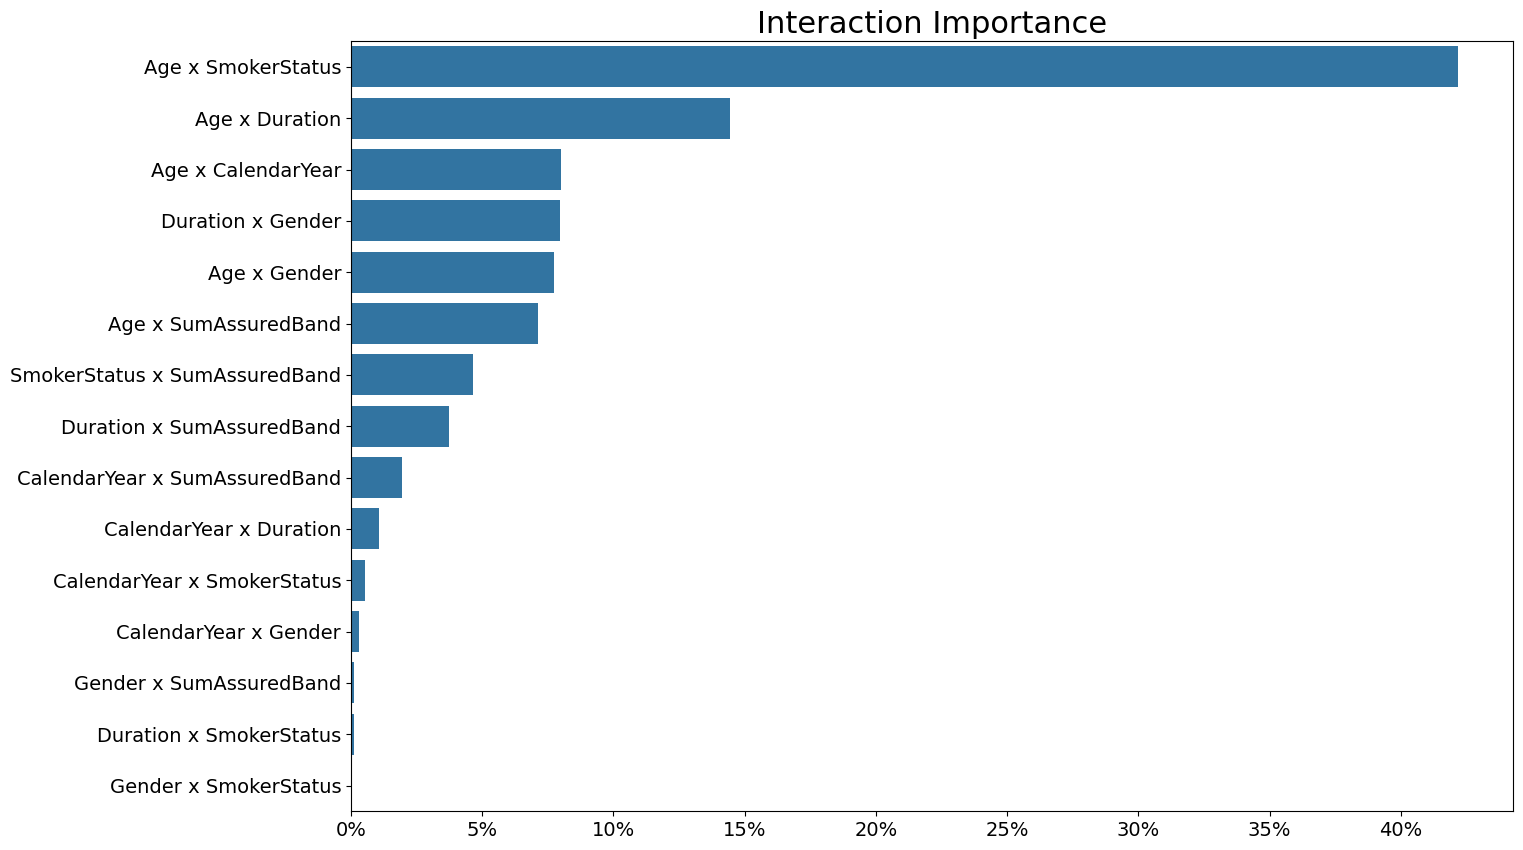

In [17]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["axes.edgecolor"] = "black"

fig, ax = plt.subplots(1)

sns.barplot(
    data=interaction_imp, 
    y="Feature_List", 
    x="Gain_Norm", 
    color="tab:blue", 
    ax=ax,
)

# Do some formating in the x and y axes to make them easier to read
xticker = ax.get_xticks() 
xlabel = [f'{x:,.0%}' for x in xticker]
ax.set_xticklabels(xlabel, fontsize=tick_fontsize)

ylabel = interaction_imp["Feature_List"] 
ax.set_yticklabels(ylabel, fontsize=tick_fontsize)

ax.set_facecolor("white")

ax.set_xlabel("")
ax.set_ylabel("")

ax.set_title("Interaction Importance", fontsize=title_fontsize)

In [18]:
############################################
############################################

# Define number of interaction terms included 
num_inter = 5

############################################
############################################

interaction_list = list(interaction_imp.loc[:num_inter, "Feature_List1"])
print(interaction_list)

[('Age_level', 'SmokerStatus_cat_level'), ('Age_level', 'Duration_level'), ('Age_level', 'CalendarYear_cat_level'), ('Duration_level', 'Gender_cat_level'), ('Age_level', 'Gender_cat_level'), ('Age_level', 'SumAssuredBand_level')]


### Define GAM term structure

In [19]:
term_string, num_feat_map, cat_feat_map, inter_feat_map = (
    training.create_term_structure(
        num_feat, 
        cat_feat, 
        X_train_rs,
        interaction_list
    )
)
print(term_string)

s(0, lam=lam_num, n_splines=n_splines)+ s(2, lam=lam_num, n_splines=n_splines)+ s(4, lam=lam_num, n_splines=n_splines) + f(1, lam=lam_cat) + f(3, lam=lam_cat) + f(5, lam=lam_cat) + te(0, 1, lam=[lam_num_inter, lam_cat_inter], n_splines=[n_splines_inter, 4], constraints=[None, None], dtype=['numerical', 'categorical']) + te(0, 2, lam=[lam_num_inter, lam_num_inter], n_splines=[n_splines_inter, n_splines_inter], constraints=[None, None], dtype=['numerical', 'numerical']) + te(0, 5, lam=[lam_num_inter, lam_cat_inter], n_splines=[n_splines_inter, 5], constraints=[None, None], dtype=['numerical', 'categorical']) + te(2, 3, lam=[lam_num_inter, lam_cat_inter], n_splines=[n_splines_inter, 4], constraints=[None, None], dtype=['numerical', 'categorical']) + te(0, 3, lam=[lam_num_inter, lam_cat_inter], n_splines=[n_splines_inter, 4], constraints=[None, None], dtype=['numerical', 'categorical']) + te(0, 4, lam=[lam_num_inter, lam_num_inter], n_splines=[n_splines_inter, n_splines_inter], constraints

In [20]:
# In any unseen data, any categorical level not in the training set will be mapped to the mode of the training set
for v in cat_feat:
    unique_level = X_train_rs[v].unique()
    condition = X_test[v].isin(unique_level)
    X_test[v] = np.where(condition, X_test[v], X_train_rs[v].mode().iloc[0])
X_test

,Age_level,SmokerStatus_cat_level,Duration_level,Gender_cat_level,SumAssuredBand_level,CalendarYear_cat_level
unique_id,,,,,,
5,22,0,11,0,5,0
6,27,0,11,0,5,0
16,34,0,11,0,4,0
26,36,0,11,0,5,0
38,26,0,11,0,5,0
...,...,...,...,...,...,...
2535416,12,1,1,1,3,4
2535420,16,1,1,1,3,4
2535428,24,1,1,1,3,4


### Model training

In [21]:
###########################################################################
###########################################################################

modelling_log = f"04_model_note_{product.lower()}_{model_type.lower()}_{model_version}.xlsx"

###########################################################################
###########################################################################

study_df = pd.read_excel(f"{dir_output}/{modelling_log}", "Final_Tune")
best_params = study_df.sort_values("value").filter(regex="params_").iloc[0].to_dict()
best_params = {k.replace("params_", ""): v for k, v in best_params.items()}

n_splines = int(best_params["n_splines"])
lam_num = best_params["lam_num"]
lam_cat = best_params["lam_cat"]
n_splines_inter = 5

# As a heuristic, set hyperparameters related to interactions to be the same as single factor's
lam_num_inter = lam_num
lam_cat_inter = lam_cat

print(f"{'n_splines':<18}: {n_splines}")
print(f"{'lam_num':<18}: {lam_num}")
print(f"{'lam_cat':<18}: {lam_cat}")
print(f"{'n_splines_inter':<18}: {n_splines_inter}")
print(f"{'lam_num_inter':<18}: {lam_num_inter}")
print(f"{'lam_cat_inter':<18}: {lam_cat_inter}")

n_splines         : 9
lam_num           : 1.00092693183052
lam_cat           : 2.217705498478466
n_splines_inter   : 5
lam_num_inter     : 1.00092693183052
lam_cat_inter     : 2.217705498478466


In [47]:
# Fit the GAM model
gam_final = GAM(
    eval(term_string),
    distribution="poisson",
    link="log",
).fit(X_train_rs, y_train_rs, weights=w_train_rs)

gam_final.summary()

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                     40.1302
Link Function:                          LogLink Log Likelihood:                                       -inf
Number of Samples:                      1535099 AIC:                                                   inf
                                                AICc:                                                  inf
                                                UBRE:                                                2.126
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.642
Feature Function                  Lam

In [48]:
###########################################################################
###########################################################################

filename = f"{dir_output}/{product.lower()}_{model_type.lower()}_final_{model_version}.pkl"

###########################################################################
###########################################################################

# Save the GAM model as a pickle file 
with open(filename, 'wb') as file:
    pickle.dump(gam_final, file)

### Derive associated relativities

In [22]:
###########################################################################
###########################################################################

filename = f"{dir_output}/{product.lower()}_{model_type.lower()}_final_{model_version}.pkl"

###########################################################################
###########################################################################

# Re-load the GAM model
with open(filename, "rb") as file:
    gam_final = pickle.load(file)

In [23]:
###########################################################################
###########################################################################

num_band_loc = f"{dir_input}/CMI Numerical Bands.xlsx"
cat_band_loc = f"{dir_data}/CMI DB Categorical Bands (with CalendarYear).xlsx"

###########################################################################
###########################################################################

# Extracting relativities by rating factors is necessary to implement the model in a rating-table strucutre
intercept, num_rel_dict, cat_rel_dict, inter_rel_dict = training.extract_relativity(
    num_feat_map,
    cat_feat_map,
    X_train_rs.join(w_train_rs), 
    gam_final,
    num_band_loc,
    cat_band_loc,
    weight=weight,
    base_adj=base_adj,
    interact_term_map=inter_feat_map,
)
print(intercept)

0.0011258633516515002


In [24]:
# Check one set of relativities for a rating factor
num_rel_dict["SumAssuredBand_level"]

,SumAssuredBand_level,pred,relativity,LivesExposure,rel_weight
0,1,0.873270,1.379278,1.576103e+06,1.376364e+06
1,2,0.761249,1.202347,4.298695e+06,3.272375e+06
2,3,0.653241,1.031755,5.739795e+06,3.749470e+06
3,4,0.564122,0.890998,7.608686e+06,4.292230e+06
4,5,0.472648,0.746520,3.236990e+06,1.529958e+06


In [25]:
# Check one set of relativities for an interaction term
inter_rel_dict['Age_level x SmokerStatus_cat_level'].head(5)

,Age_level,SmokerStatus_cat_level,pred,relativity,LivesExposure,rel_weight
0,1,0,1.234519,1.252043,756.686818,934.144002
1,1,1,0.796620,0.807928,146.448432,116.663742
2,2,0,1.228002,1.245434,2442.126671,2998.937657
3,2,1,0.800443,0.811805,517.113452,413.919679
4,3,0,1.221111,1.238445,5228.652946,6384.767643


## Holdout Assessment

In [ ]:
###########################################################################
###########################################################################


ypred_sing_filename = f"ypred_single_factor_gam_{model_version}.parquet"
sing_pred_count = "gam_claim_count"

###########################################################################
###########################################################################

# Import single factor predictions 
ypred_sing_df = pd.read_parquet(f"{dir_output}/{ypred_sing_filename}")
ypred_sing_df[sing_pred_count] *= base_adj

ypred_sing_df

In [ ]:
###########################################################################
###########################################################################

# Column name of final predictions
final_pred_freq = "gam_freq_final"
final_pred_count = "gam_claim_count_final"

###########################################################################
###########################################################################

# Perform final model scoring 
ypred_test_df = pd.DataFrame(index=X_test.index)
ypred_test_df[final_pred_freq] = gam_final.predict(X_test) * base_adj
ypred_test_df = ypred_test_df.join(ypred_sing_df)
ypred_test_df[final_pred_count] = (
    ypred_test_df[final_pred_freq] * ypred_test_df[weight]
)
ypred_test_df

### Deviance loss

In [28]:
###########################################################################
###########################################################################

cmi_base = "ExpectedClaims"

###########################################################################
###########################################################################

final_dev = utility.total_poisson_dev(
    y=ypred_test_df[claim_count], 
    y_pred=ypred_test_df[final_pred_count],
)
sing_dev = utility.total_poisson_dev(
    y=ypred_test_df[claim_count], 
    y_pred=ypred_test_df[sing_pred_count],
)
cmi_dev = utility.total_poisson_dev(
    y=ypred_test_df[claim_count], 
    y_pred=ypred_test_df[cmi_base],
)

print(f"{'GAM (Single-Factor)':<20}: {sing_dev:,.0f}")
print(f"{'GAM (Final)':<20}: {final_dev:,.0f}")
print(f"{'CMI Base':<20}: {cmi_dev:,.0f}")

GAM (Single-Factor) : 52,929
GAM (Final)         : 52,862
CMI Base            : 52,946


### Double Lift

In [29]:
predict = [final_pred_count, sing_pred_count]

d = utility.DoubleLift(
    ypred_test_df, predict, claim_count, weight, [0.02, 0.98], approx_num_band=25
)

mape_final = mean_absolute_percentage_error(
    d.double_lift_table[claim_count],
    d.double_lift_table[final_pred_count],
    sample_weight=d.double_lift_table[weight],
)
mape_sing = mean_absolute_percentage_error(
    d.double_lift_table[claim_count],
    d.double_lift_table[sing_pred_count],
    sample_weight=d.double_lift_table[weight],
)
print(f"{'MAPE - GAM (Single Factor)':<28}: {mape_sing:.2%}")
print(f"{'MAPE - GAM Final':<28}: {mape_final:.2%}")

MAPE - GAM (Single Factor)  : 8.53%
MAPE - GAM Final            : 2.65%


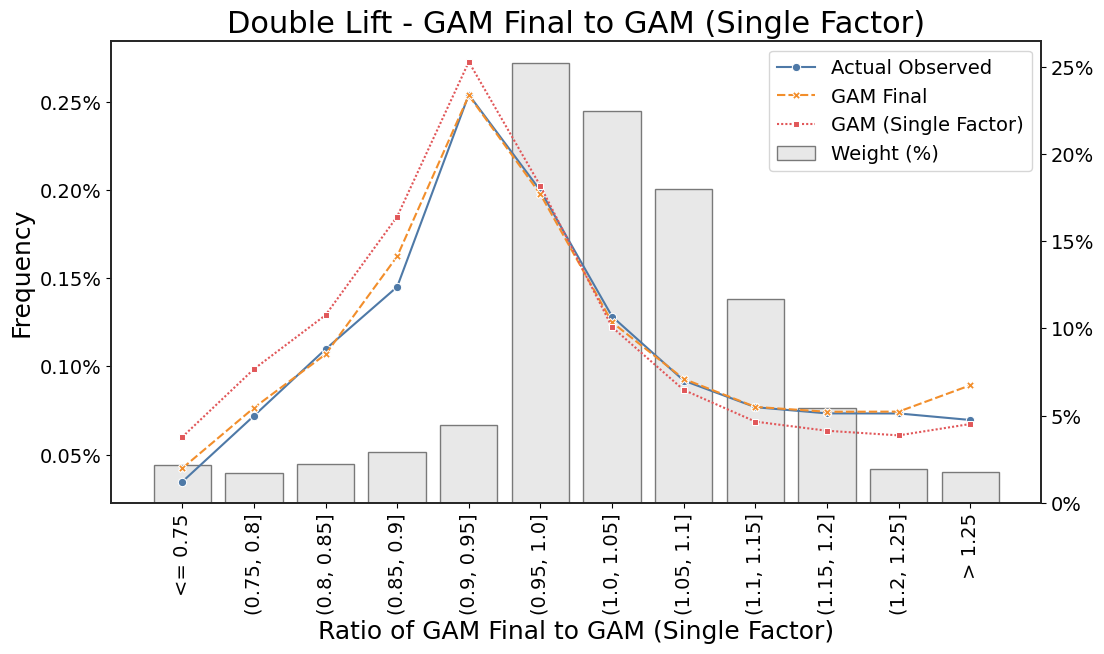

In [30]:
###########################################################################
###########################################################################

param_dict = {
    "title": "Double Lift - GAM Final to GAM (Single Factor)", 
    "leftylabel": "Frequency", 
    "rightylabel": "Weight (%)",
    "target_legend": "Actual Observed", 
    "new_model_legend": "GAM Final",
    "baseline_legend": "GAM (Single Factor)",
}

###########################################################################
###########################################################################

plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"] = 1.25

fig, ax = plt.subplots(figsize=(12, 6))

d.plot_double_lift(ax=ax, **param_dict)

In [31]:
predict = [final_pred_count, cmi_base]

d = utility.DoubleLift(
    ypred_test_df, predict, claim_count, weight, [0.04, 0.96], approx_num_band=25
)

mape_final = mean_absolute_percentage_error(
    d.double_lift_table[claim_count],
    d.double_lift_table[final_pred_count],
    sample_weight=d.double_lift_table[weight],
)
mape_cmi = mean_absolute_percentage_error(
    d.double_lift_table[claim_count],
    d.double_lift_table[cmi_base],
    sample_weight=d.double_lift_table[weight],
)
print(f"{'MAPE - CMI Base':<28}: {mape_cmi:.2%}")
print(f"{'MAPE - GAM Final':<28}: {mape_final:.2%}")

MAPE - CMI Base             : 9.31%
MAPE - GAM Final            : 4.33%


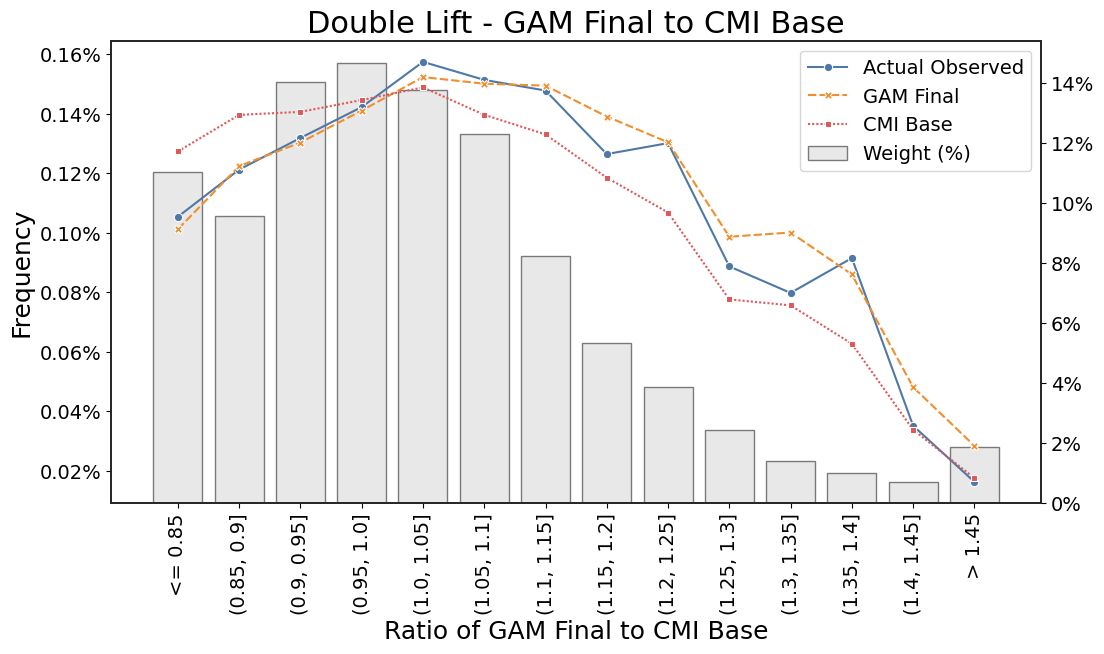

In [32]:
###########################################################################
###########################################################################

param_dict = {
    "title": "Double Lift - GAM Final to CMI Base", 
    "leftylabel": "Frequency", 
    "rightylabel": "Weight (%)",
    "target_legend": "Actual Observed", 
    "new_model_legend": "GAM Final",
    "baseline_legend": "CMI Base",
}

###########################################################################
###########################################################################

plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"] = 1.25

fig, ax = plt.subplots(figsize=(12, 6))

d.plot_double_lift(ax=ax, **param_dict)

## Model Interpretation 
### Factor Importance

In [57]:
single_fact_df, interaction_df = explain.factor_strength(
    num_rel_dict, 
    cat_rel_dict, 
    inter_rel_dict=inter_rel_dict, 
    weight=weight,
)

# Update the interaction terms to string formats 
interaction_df["interaction1"] = interaction_df.apply(
    lambda x: x.feature1 + " x " + x.feature2, axis=1
)
interaction_df["feature1_full"] = interaction_df.apply(
    lambda x: (
        x.feature1 + "_level" 
        if x.feature1_type == "numerical" 
        else x.feature1 + "_cat_level"
    ), 
    axis=1,
)
interaction_df["feature2_full"] = interaction_df.apply(
    lambda x: (
        x.feature2 + "_level" 
        if x.feature2_type == "numerical" 
        else x.feature2 + "_cat_level"
    ), 
    axis=1,
)
interaction_df["interaction2"] = interaction_df.apply(
    lambda x: x.feature1_full + " x " + x.feature2_full, axis=1
)
interaction_df

,interaction_term,feature1,feature2,feature1_type,feature2_type,factor_strength,interaction1,feature1_full,feature2_full,interaction2
0,"(Age, Duration)",Age,Duration,numerical,numerical,0.111090,Age x Duration,Age_level,Duration_level,Age_level x Duration_level
1,"(Age, SumAssuredBand)",Age,SumAssuredBand,numerical,numerical,0.091664,Age x SumAssuredBand,Age_level,SumAssuredBand_level,Age_level x SumAssuredBand_level
2,"(Age, SmokerStatus)",Age,SmokerStatus,numerical,categorical,0.089731,Age x SmokerStatus,Age_level,SmokerStatus_cat_level,Age_level x SmokerStatus_cat_level
3,"(Duration, Gender)",Duration,Gender,numerical,categorical,0.060465,Duration x Gender,Duration_level,Gender_cat_level,Duration_level x Gender_cat_level
4,"(Age, CalendarYear)",Age,CalendarYear,numerical,categorical,0.037154,Age x CalendarYear,Age_level,CalendarYear_cat_level,Age_level x CalendarYear_cat_level
5,"(Age, Gender)",Age,Gender,numerical,categorical,0.023624,Age x Gender,Age_level,Gender_cat_level,Age_level x Gender_cat_level


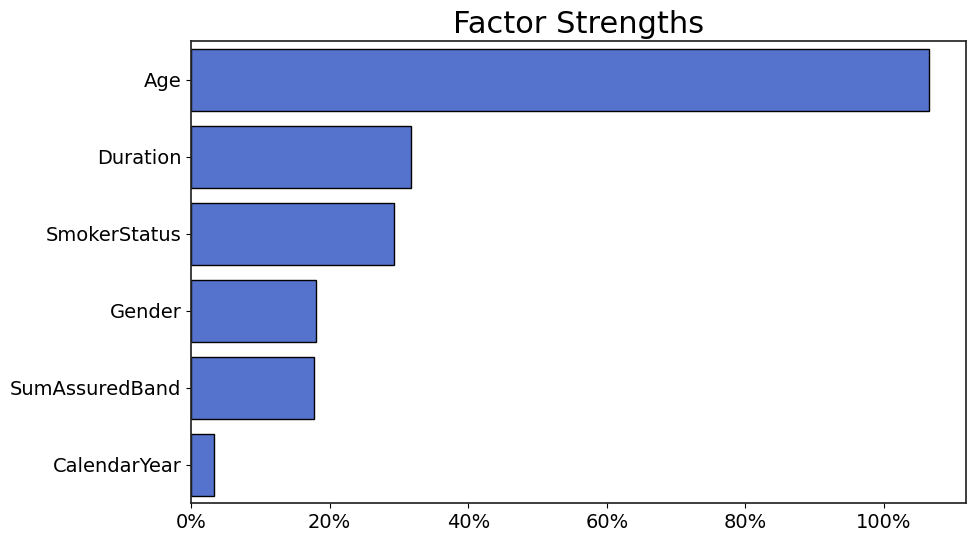

In [52]:
plt.rcParams["figure.figsize"] = [10, 6]
fig, ax = plt.subplots(1)
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"]  = 1.25

# Plot data
sns.barplot(
    x="factor_strength",
    y="feature",
    data=single_fact_df,
    ax=ax,
    color="royalblue",
    edgecolor="black",
)

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.0%}"))
ax.tick_params(axis="both", which="major", labelsize=tick_fontsize)
ax.set_title(
    f"Factor Strengths", fontsize=title_fontsize
)
ax.set_xlabel("")
ax.set_ylabel("")
ax.grid(False)

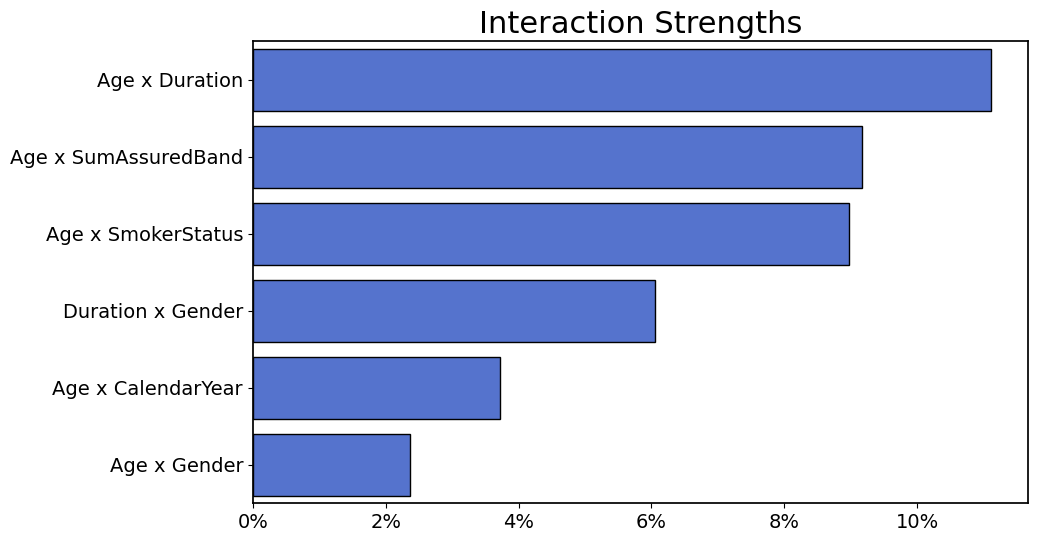

In [53]:
plt.rcParams["figure.figsize"] = [10, 6]
fig, ax = plt.subplots(1)
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"]  = 1.25

# Plot data
sns.barplot(
    x="factor_strength",
    y="interaction1",
    data=interaction_df,
    ax=ax,
    color="royalblue",
    edgecolor="black",
)

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.0%}"))
ax.tick_params(axis="both", which="major", labelsize=tick_fontsize)
ax.set_title(
    f"Interaction Strengths", fontsize=title_fontsize
)
ax.set_xlabel("")
ax.set_ylabel("")
ax.grid(False)

### Rating factor trends

In [36]:
plot_object = explain.RatingFactorTrend(
    num_rel_dict,
    cat_rel_dict,
    num_band_loc,
    cat_band_loc,
    inter_rel_dict,
    weight=weight,
)

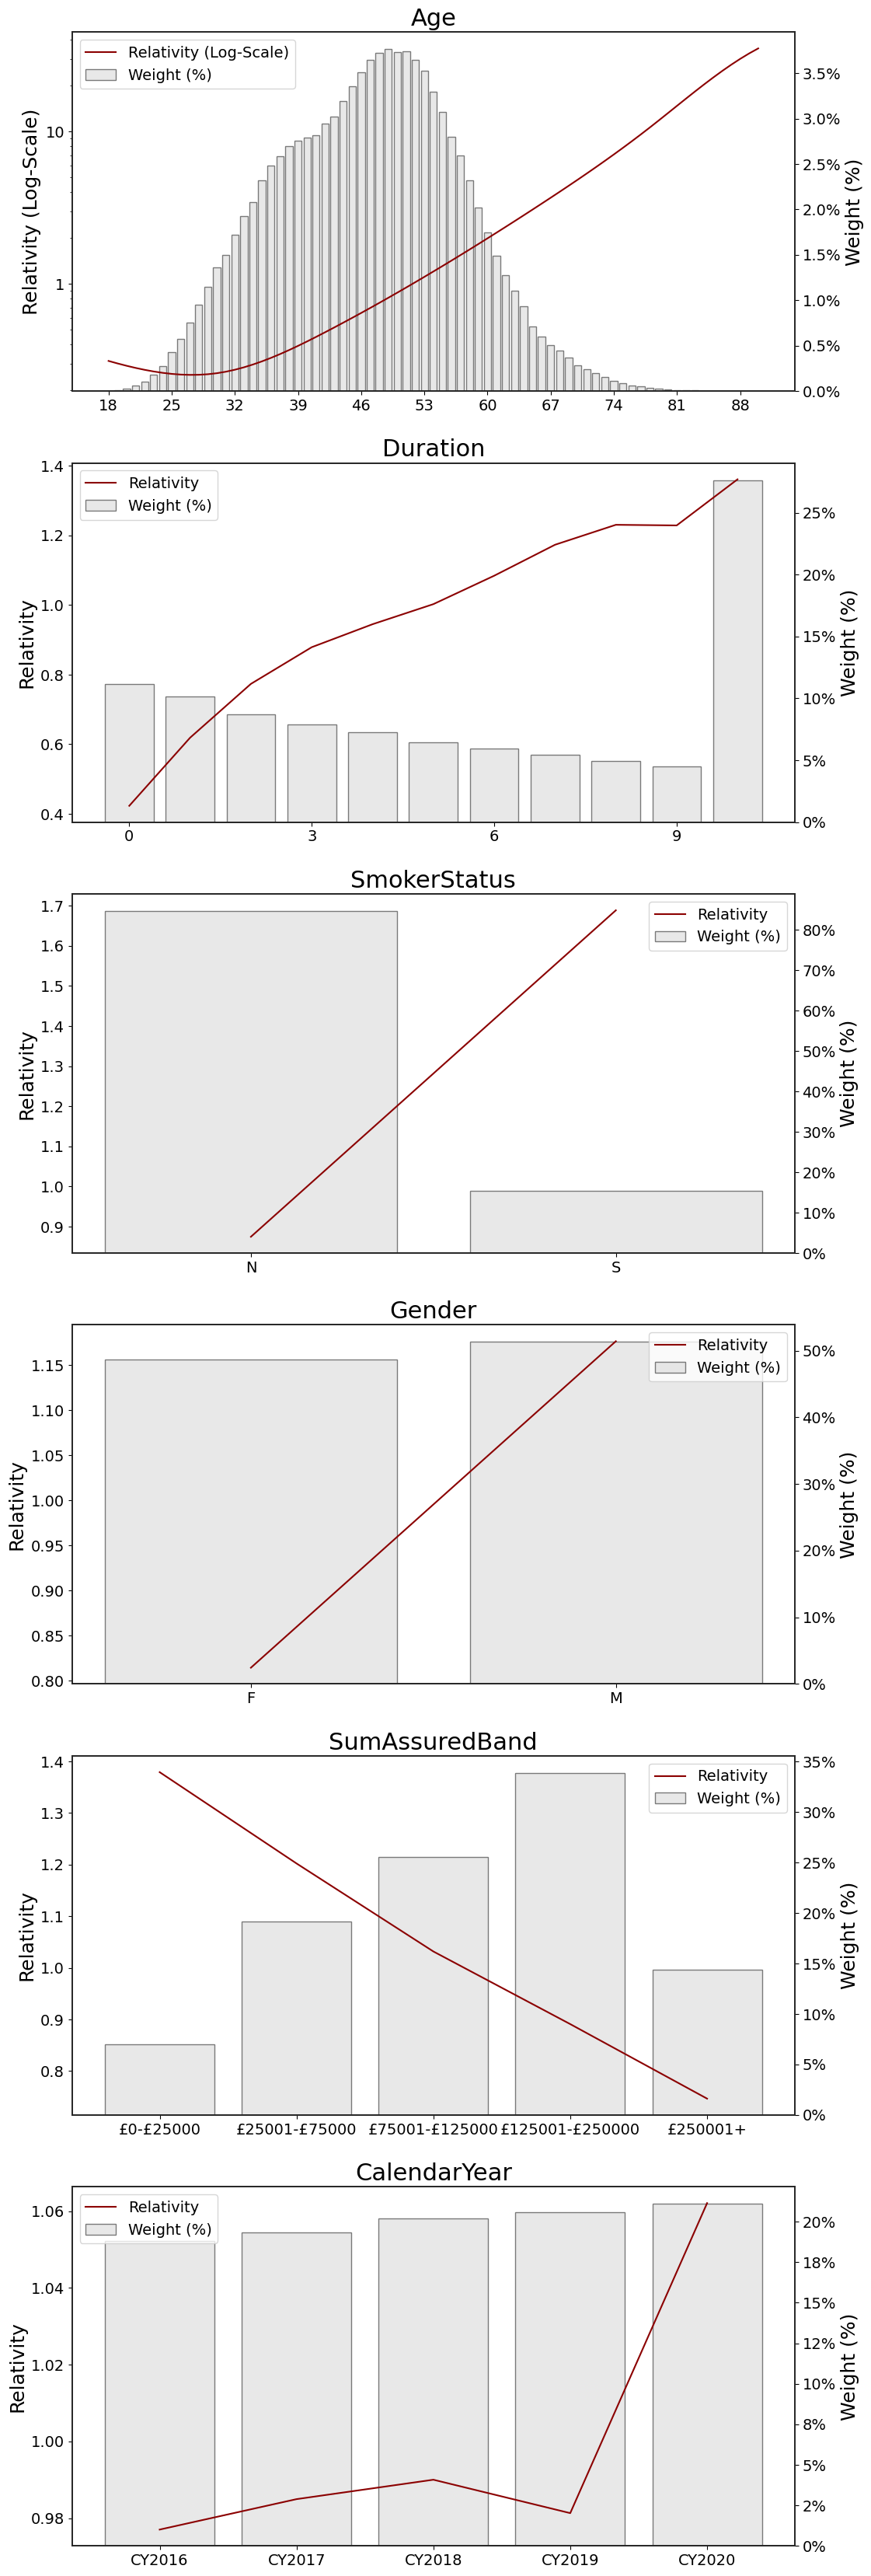

In [37]:
###########################################################################
###########################################################################

# Set the number of numerical variables to plot 
num_plot = len(single_fact_df)

###########################################################################
###########################################################################

# plotting
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25
plt.rcParams["figure.figsize"] = [12, 7 * num_plot]

fig, axs = plt.subplots(num_plot, 1)
plt.subplots_adjust(hspace=0.2)

for i, ax in enumerate(axs): 
    feature_type = single_fact_df.feature_type.iloc[i] 
    var = single_fact_df.feature.iloc[i]
    var += "_level" if feature_type == "numerical" else "_cat_level"
    log_scale = True if var == "Age_level" else False
    plot_object.plot_trend(var, ax, log_scale=log_scale)

### Interaction trends

In [65]:
for var, rel in inter_rel_dict.items(): 
    var1, var2 = var.split(" x ")
    
    rel1 = (
        cat_rel_dict[var1] if "_cat_level" in var1 else num_rel_dict[var1]
    )
    rel2 = (
        cat_rel_dict[var2] if "_cat_level" in var2 else num_rel_dict[var2]
    )
    
    inter_rel_dict[var]["var1_rel"] = inter_rel_dict[var][var1].map(
        rel1.set_index(var1)["relativity"].to_dict()
    )
    inter_rel_dict[var]["var2_rel"] = inter_rel_dict[var][var2].map(
        rel2.set_index(var2)["relativity"].to_dict()
    )
    inter_rel_dict[var]["combined_rel"] = (
        inter_rel_dict[var]["relativity"]
        * inter_rel_dict[var]["var1_rel"]
        * inter_rel_dict[var]["var2_rel"]
    )

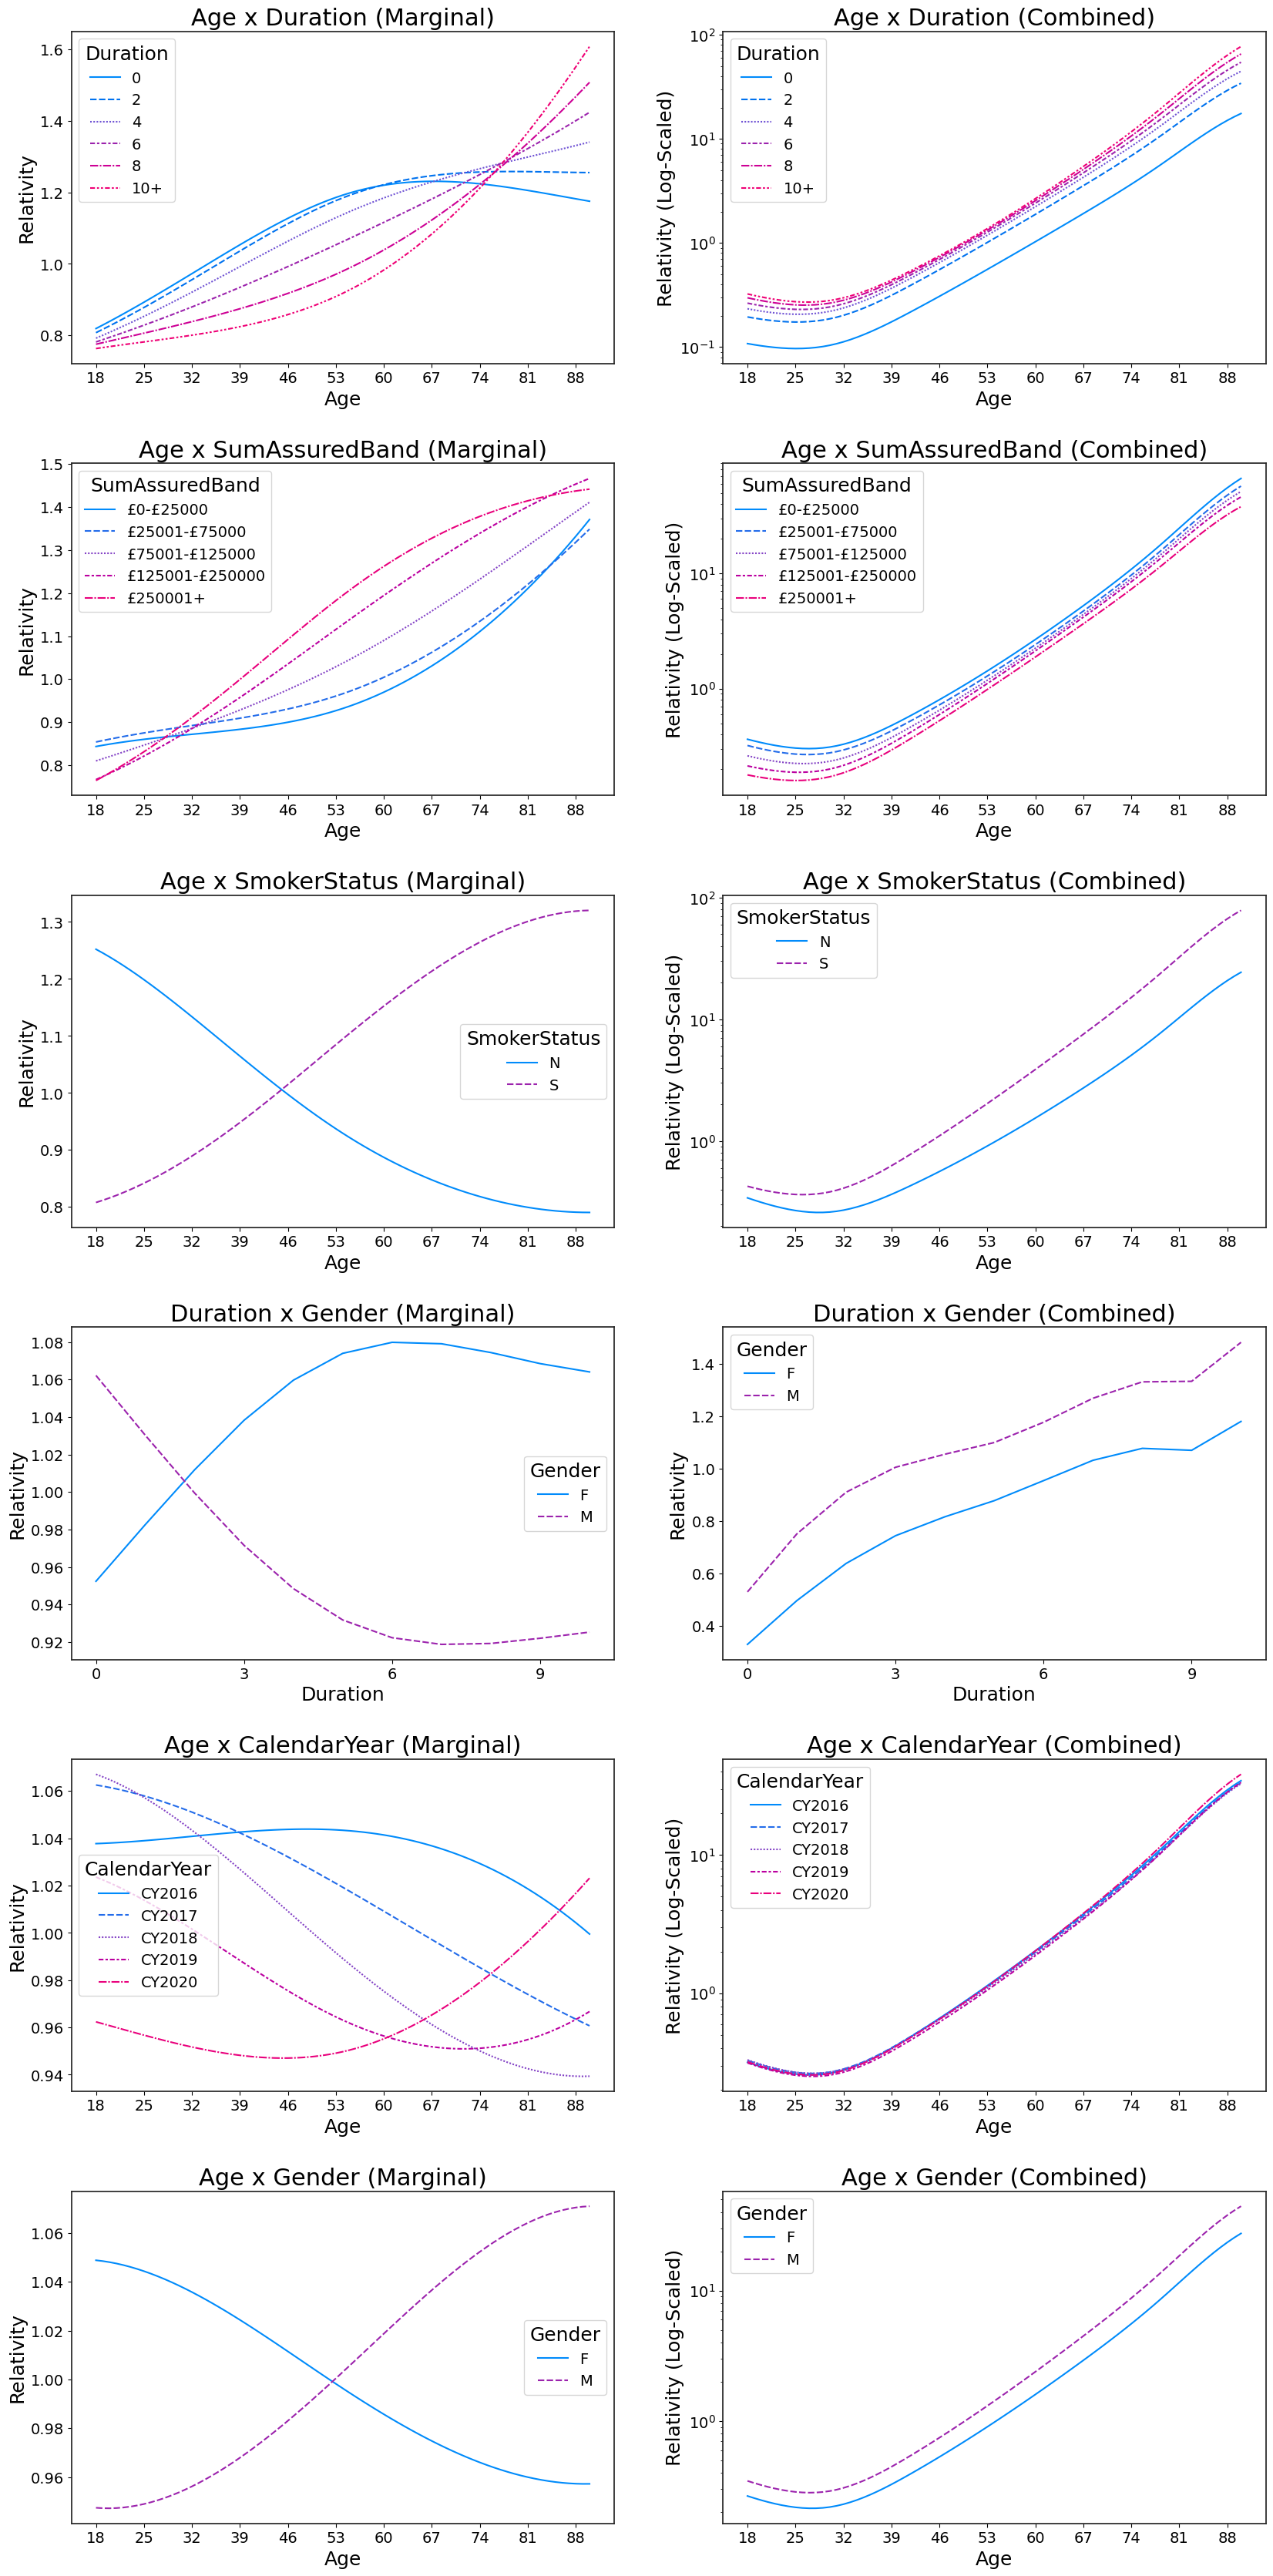

In [75]:
###########################################################################
###########################################################################

# Set the number of numerical variables to plot 
num_plot = len(interaction_df)

###########################################################################
###########################################################################

# plotting
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25
plt.rcParams["figure.figsize"] = [20, 7 * num_plot]

fig, axs = plt.subplots(num_plot, 2)
plt.subplots_adjust(hspace=0.3)

for i in range(num_plot):
    var = interaction_df.loc[i, "interaction2"]
    var1, var2 = var.split(" x ")
    
    plot_object.plot_trend(
        var, 
        axs[i, 0], 
        log_scale=False, 
        is_reversed=False, 
        value_col="relativity", 
        title_suffix = "(Marginal)"
    )
    plot_object.plot_trend(
        var, 
        axs[i, 1], 
        log_scale=True if var1 == "Age_level" else False, 
        is_reversed=False, 
        value_col="combined_rel", 
        title_suffix = "(Combined)"
    )

### Actual vs expected claim count by rating factors

In [ ]:
# Define the training dataframe with all the features used and all the rows 
X_train = model_data.loc[model_data[holdout] == 0, final_feature]

for v in cat_feat:
    unique_level = X_train_rs[v].unique()
    condition = X_train[v].isin(unique_level)
    X_train[v] = np.where(condition, X_train[v], X_train_rs[v].mode().iloc[0])

X_train

In [ ]:
# Score the training data 
ypred_train = gam_final.predict(X_train) * base_adj

ypred_train_df = pd.DataFrame(
    ypred_train, columns=[final_pred_freq], index=X_train.index
)
ypred_train_df = ypred_train_df.join(model_data[[weight, cmi_base, claim_count]])
ypred_train_df[final_pred_count] = (
    ypred_train_df[final_pred_freq] * ypred_train_df[weight]
)
ypred_train_df

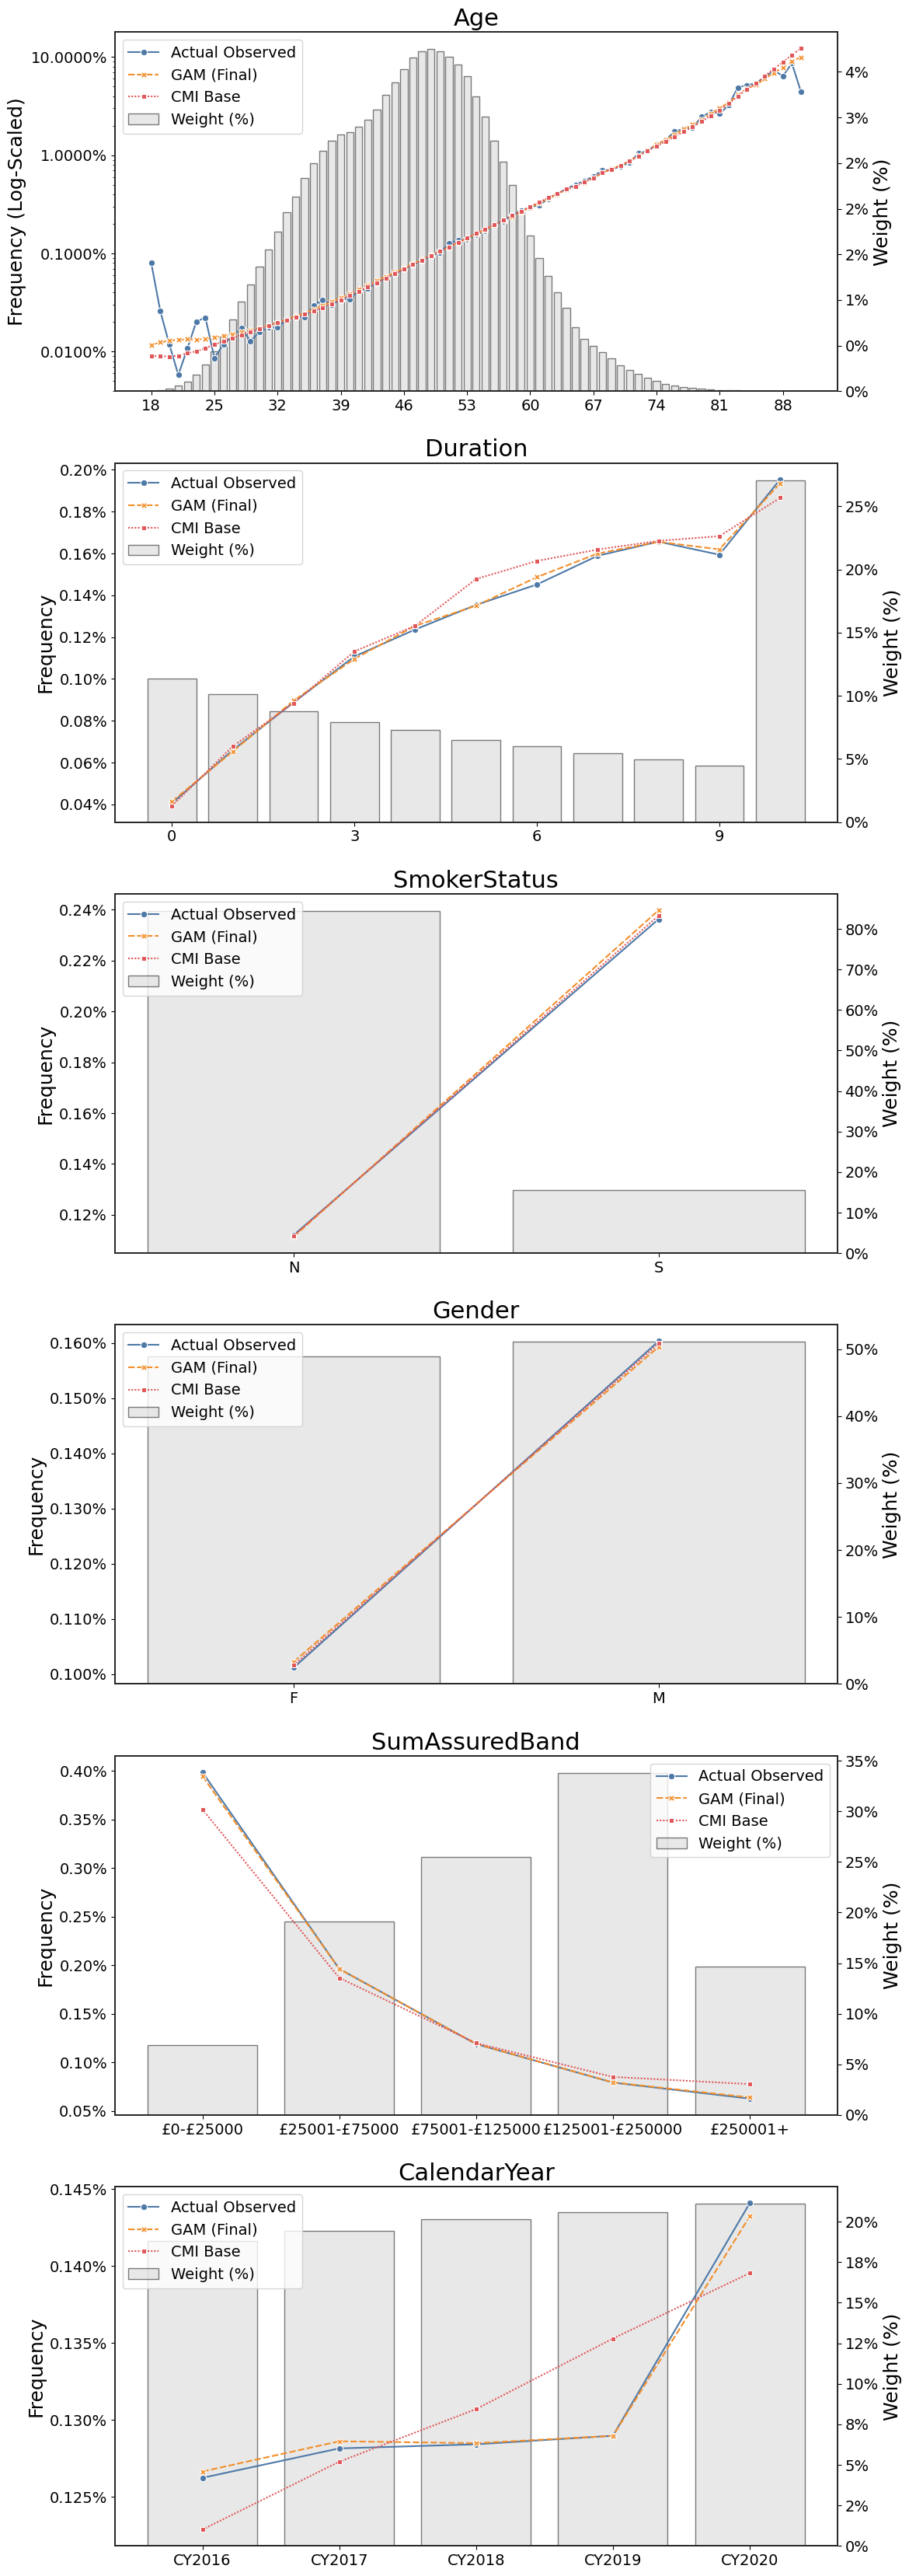

In [80]:
###########################################################################
###########################################################################

target_legend = "Actual Observed"
new_model_legend = "GAM (Final)"
baseline_legend = "CMI Base"

###########################################################################
###########################################################################

# plotting
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"] = 1.25
plt.rcParams["figure.figsize"] = [12, 7 * num_plot]

fig, axs = plt.subplots(num_plot, 1)
plt.subplots_adjust(hspace=0.2)

for i, ax in enumerate(axs):
    feature_type = single_fact_df.feature_type.iloc[i]
    var = single_fact_df.feature.iloc[i]
    var_level = var + "_level" if feature_type == "numerical" else var + "_cat_level"
    log_scale = True if var_level == "Age_level" else False
    
    ypred_dummy = ypred_train_df.join(model_data[var_level])
    utility.actual_vs_predicted(
        ypred_dummy, 
        (claim_count, target_legend), 
        {final_pred_count: new_model_legend, cmi_base: baseline_legend}, 
        weight, 
        var_level, 
        is_var_num=True if feature_type == "numerical" else False, 
        banding_loc=num_band_loc if feature_type == "numerical" else cat_band_loc, 
        plot=True,
        ax=ax, 
        log_scale=True if var_level == "Age_level" else False,
    )